# Présentation POC framework covid19

4 fonctionnalités :
- transparence
- aider à la communication y compris pour des non data-scientist
- reproductibilité
- fonctionnement "open"

# Import

In [1]:
import pandas as pd
import numpy as np

import os, sys
# Adding parent directory to python path
sys.path.append(os.path.dirname(os.getcwd()))

import ml_workflow
from ml_workflow import Rule, DataSource

import sqlite3

# Pseudo covid 19

In [2]:
personnal_data_file = 'data/train.csv'
pcr_tests_db = 'data/pcr_tests.db'
consultation_db = 'data/consultations.db'


@DataSource(name='Personnal data csv file')
def retrieve_personnal_data():
    return pd.read_csv(personnal_data_file)

@DataSource(name='Retrieve pcr tests')
def retrieve_pcr_tests():
    conn = sqlite3.connect(pcr_tests_db)
    return pd.read_sql(
        'SELECT id, person_id, pcr_result, test_date FROM pcr_test ORDER BY id',
        conn
    )

@DataSource(name='Retrieve data source')
def retrieve_visites():
    conn = sqlite3.connect(consultation_db)
    return pd.read_sql(
        'SELECT id, person_id, services, hospital, consultation_date FROM consultations ORDER BY id',
        conn
    )


    

@Rule(name='select_with_age', highlight=2)
def select_with_age(personnal_df):
    return personnal_df[np.logical_not(personnal_df['age'].isna())]
        
def get_patients_status():
    personnal_df = retrieve_personnal_data()
    personnal_df = Rule.call_from_reference_name('select_with_age')(personnal_df)
        
    return personnal_df

def get_patients_pcr_positives():
    patient_status = get_patients_status()
    
    tests_pcr = retrieve_pcr_tests()
    
    with Rule(name='pcr positif'):
        tests_pcr = tests_pcr[tests_pcr['pcr_result'] == 'positive']
    
    with Rule(name='pcr_positif_merge'):
        return patient_status.merge(tests_pcr, left_on='id', right_on='person_id')
    
def get_consultations():
    return retrieve_visites()


## Sqlite3 play-ground

## Pandas play-ground

In [3]:
get_patients_status()['age'].mean()

29.6206862745098

# User code

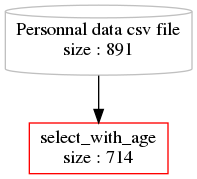

In [4]:
patient_status = get_patients_status()

patient_status.plot_model()

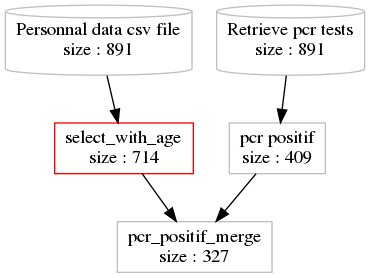

In [5]:
get_patients_pcr_positives().plot_model()

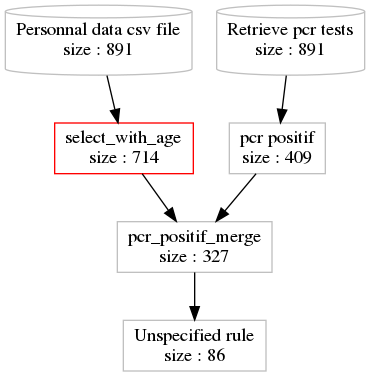

In [6]:
patients = get_patients_pcr_positives()

my_patient_status = patients[patients['age'] >= 18]
my_patient_status = my_patient_status[my_patient_status['sex'] == 'female']

my_patient_status.plot_model('graph.svg')
my_patient_status.plot_model()


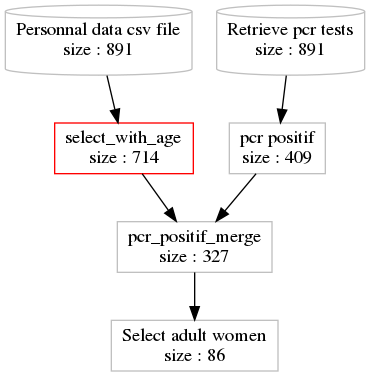

In [7]:
patients = get_patients_pcr_positives()

with Rule(name='Select adult women'):
    my_patient_status = patients[patients['age'] >= 18]
    my_patient_status = my_patient_status[my_patient_status['sex'] == 'female']

my_patient_status.plot_model('graph.png')

## Vérification de contraintes

In [8]:
def check_is_called_after(node, rule_name):
    if node.origin.name == rule_name:
        return True
    
    for parent in node.previous:
        if check_is_called_after(parent, rule_name):
            return True
        
    return False

def check_is_called_after_rule(leaf_node, rule_1, rule_2):
    if isinstance(leaf_node, pd.DataFrame):
        return check_is_called_after_rule(leaf_node.ml_workflow_node, rule_1, rule_2)
    
    result = True
    for node in leaf_node.get_all_nodes():
        if node.origin.name == rule_1:
            result = result and check_is_called_after(node, rule_2)
            
    return result

print(check_is_called_after_rule(my_patient_status, 'select_with_age', 'Personnal data csv file'))
print(check_is_called_after_rule(my_patient_status, 'select_with_age', 'Retrieve pcr tests'))

True
False


# Fonctionnalité reproductibilité

In [9]:
conn = sqlite3.connect(pcr_tests_db)
conn.execute("UPDATE pcr_test SET pcr_result = 'positive' WHERE pcr_result = 'Positif'")
conn.commit()

Nb patients : 327
Nb patients : 0


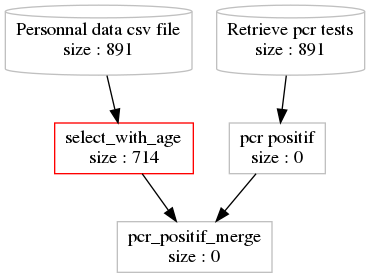

In [10]:
from ml_workflow.session import Session   
    


with Session.record_data_source('temp/test_session_record'):
    patients = get_patients_pcr_positives()

print(f"Nb patients : {len(patients)}")

conn = sqlite3.connect(pcr_tests_db)
conn.execute("UPDATE pcr_test SET pcr_result = 'Positif' WHERE pcr_result = 'positive'")
conn.commit()

patients = get_patients_pcr_positives()
print(f"Nb patients : {len(patients)}")

patients.plot_model('graph.png')

In [11]:
with Session.play_data_source_record('temp/test_session_record'):
    patients = get_patients_pcr_positives()
    
print(f"Nb patients : {len(patients)}")

Nb patients : 327


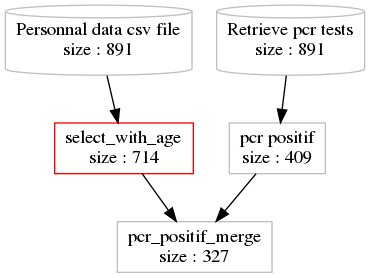

In [12]:
patients.plot_model()

## Cleaning db for the other cells

In [13]:
conn = sqlite3.connect(pcr_tests_db)
conn.execute("UPDATE pcr_test SET pcr_result = 'positive' WHERE pcr_result = 'Positif'")
conn.commit()

# Fonctionnalité versionning

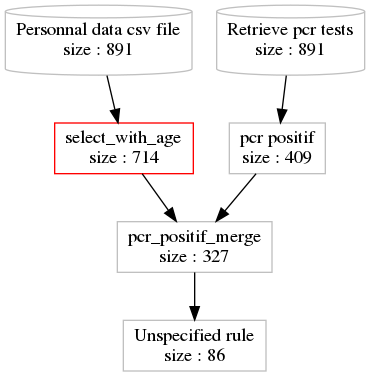

In [14]:
patients = get_patients_pcr_positives()

my_patient_status = patients[patients['age'] >= 18]
my_patient_status = my_patient_status[my_patient_status['sex'] == 'female']

my_patient_status.plot_model('graph.png')

# Fonctionnalité de choix de version de règles

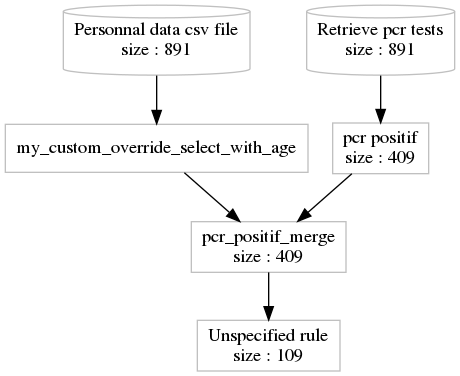

In [15]:
@Rule(name='my_custom_override_select_with_age')
def my_custom_override_select_with_age(df):
    df.loc[df['age'].isna(), 'age'] = df['age'].mean()
    
    return df

Rule.set_for_reference_name('select_with_age', my_custom_override_select_with_age)

patients = get_patients_pcr_positives()

my_patient_status = patients[patients['age'] >= 18]
my_patient_status = my_patient_status[my_patient_status['sex'] == 'female']

my_patient_status.plot_model('graph.png')

In [16]:
Rule.unset_for_reference_name('select_with_age')